In [28]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Concatenate data from all subjects and all sessions
mycwd = os.getcwd()

path = r'/home/amoran/YASA/SWSdata/all_N3'
os.chdir(path)
all_files = glob.glob("*.csv")
df_from_each_file = (pd.read_csv(f) for f in all_files)
newdf =  []
for i, dff in enumerate(df_from_each_file):
    dff['Group']= all_files[i][0]
    dff['Subject'] = all_files[i][0:3]
    dff['Session'] = all_files[i][4]
    newdf.append(dff)

os.chdir(mycwd)

# Construct dataframe
concatenated_df = pd.concat(newdf, ignore_index=True)
concatenated_df.rename(columns={'Unnamed: 0':'Wave'}, inplace=True)
concatenated_df.loc[:,'Session'] = concatenated_df['Session'].astype(int)
concatenated_df.loc[:,'Start'] = concatenated_df['Start']/3600

# Name channels
chan_list = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 
             'A1', 'T7', 'C5', 'C3', 'Cz', 'C4', 'C6', 'T8', 'A2', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 
             'P4', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
for i in range(len(chan_list)):
    concatenated_df.loc[(concatenated_df.Channel == 'EEG ' + chan_list[i]), 'Channel'] = chan_list[i]

# Add age
age = pd.read_csv('/home/amoran/YASA/SWSdata/NMDA-age.csv', usecols = ['Subject','Session','Birthdate','Testdate'])
age.loc[:,('Birthdate','Testdate')] = age.loc[:,('Birthdate','Testdate')].apply(pd.to_datetime)
age['Age'] = ((age['Testdate']-age['Birthdate']).apply(lambda r:r.days))/365.25
age['Age'] = round(age['Age'],2)
concatenated_df = concatenated_df.merge(age[['Subject','Session','Age']], on = ['Subject','Session'])


# Old/New system
concatenated_df['Machine'] = 'O'

subj1 = ['C22','C23','C21','C25','E17','E18','E20','E21','E22','E24','E25','E26','E27','S15','S16','S17','S18','S19','S20','S21','S22']
subj2 = ['E18','E20','E22']
subj3 = ['E13','E16','E17','E18']
subj4 = ['C13','C14','C15','C16','C20','C21','C23','E09','E10','E11','E13','E14','E15','E16','E18','S07','S08','S11','S12']
concatenated_df.loc[(concatenated_df['Session']==1)&concatenated_df.Subject.isin(subj1), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==2)&concatenated_df.Subject.isin(subj2), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==3)&concatenated_df.Subject.isin(subj3), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==4)&concatenated_df.Subject.isin(subj4), 'Machine'] = 'N'


concatenated_df = concatenated_df.sort_values(by = ['Subject','Session','Start'])

In [ ]:
concatenated_df

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine
2819111,0,0.263417,948.93,949.21,949.37,949.52,1.22,-99.451261,40.264333,139.715594,498.984264,0.819672,2,Fp1,0,C,C02,1,22.91,O
2821183,2072,0.263503,948.91,949.11,949.34,949.54,0.93,-47.567302,57.325832,104.893134,524.465670,1.075269,2,Fpz,1,C,C02,1,22.91,O
2842637,23526,0.390594,1406.61,1406.99,1407.54,1407.86,1.72,-41.000357,45.505349,86.505706,227.646594,0.581395,2,FT8,15,C,C02,1,22.91,O
2843378,24267,0.390614,1406.66,1407.04,1407.50,1407.82,1.61,-62.808547,76.158474,138.967022,365.702689,0.621118,2,T7,17,C,C02,1,22.91,O
2844194,25083,0.390683,1406.79,1407.17,1407.61,1407.90,1.44,-71.977917,63.284502,135.262419,355.953733,0.694444,2,C5,18,C,C02,1,22.91,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376601,66872,7.985675,28748.68,28748.90,28749.12,28749.42,0.99,-60.382426,56.412705,116.795131,530.886958,1.010101,2,PO4,38,S,S22,1,18.30,N
2364194,54465,7.986847,28752.99,28753.25,28753.49,28753.86,1.21,-47.168157,36.646719,83.814876,322.364906,0.826446,2,CPz,27,S,S22,1,18.30,N
2370405,60676,7.986847,28753.01,28753.27,28753.51,28753.90,1.25,-49.500273,39.891287,89.391560,343.813691,0.800000,2,Pz,32,S,S22,1,18.30,N
2357699,47970,7.986858,28753.00,28753.25,28753.50,28753.87,1.18,-43.927471,38.041350,81.968821,327.875285,0.847458,2,C4,21,S,S22,1,18.30,N


In [ ]:
concatenated_df.to_pickle('./concatenated_dfn3_oct.pkl')
age.to_pickle('./age_oct.pkl')

In [ ]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
data = concatenated_df[crs1]
# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')
# Data all groups sessions 1-4
data4 = concatenated_df[(crs1 | crs2 | crs3 | crs4)]
# Data encephalitis for 4 sessions
cridataE = cri1 & (crs1 | crs2 | crs3 | crs4)
dataE = concatenated_df[cridataE]

/tmp/ipykernel_1588140/1384753106.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ConfArousal'] = 0


In [ ]:
# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
chan_p = ['P3', 'Pz', 'P4', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']

data_fp['Position'] = 'F'
data_fp.loc[data_fp.Channel.isin(chan_p),'Position'] = 'P'

data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)

/tmp/ipykernel_1588140/2125642727.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'F'


In [ ]:
# Subsets A/P data
crC = data_fp['Group'] == 'C'
crE = data_fp['Group'] == 'E'
crS = data_fp['Group'] == 'S'
crE1 = data_fp['Session'] == 1
crE2 = data_fp['Session'] == 2
crE3 = data_fp['Session'] == 3
crE4 = data_fp['Session'] == 4

data_fp1 = data_fp[crE1]
data4 = data_fp[(crE1 | crE2 | crE3 | crE4)]
dataE_fp = data_fp[crE & (crE1 | crE2 | crE3 | crE4)]
dataCE_fp = data_fp[(crE | crC) & (crE1 | crE2 | crE3 | crE4)]

## Check age

In [ ]:
age['Group'] = age['Subject'].str[0]
age.tail(9)

,Subject,Session,Birthdate,Testdate,Age,Group
127,E16,4,1961-05-23 00:00:00,2019-07-25 00:00:00,58.17,E
128,E18,4,1993-03-10 00:00:00,2020-02-27 00:00:00,26.97,E
129,S03,4,2000-04-13 00:00:00,2018-07-19 00:00:00,18.26,S
130,S05,4,1986-04-01 00:00:00,2019-11-08 00:00:00,33.60,S
131,S07,4,2002-06-21 00:00:00,2019-03-28 00:00:00,16.77,S
132,S08,4,2003-05-09 00:00:00,2019-03-27 00:00:00,15.88,S
133,S11,4,2003-05-15 00:00:00,2019-11-07 00:00:00,16.48,S
134,S12,4,1998-03-04 00:00:00,2019-09-05 00:00:00,21.51,S
135,S15,4,2000-06-18 00:00:00,2020-02-20 00:00:00,19.67,S


average age: 26.050588235294118
average age controls: 25.523043478260874
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


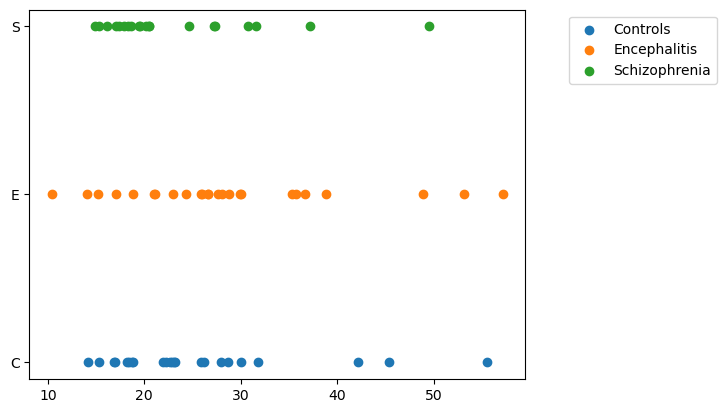

In [ ]:
# Session 1
print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

## Individual plots

In [ ]:
dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
dataC11 = dataC11.set_index('Time')
dataC11

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,Frequency,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,ConfArousal
Time,,,,,,,,,,,,,,,,,,,,,


In [ ]:
dataC11.Slope.rolling('1000s').mean()

Series([], Name: Slope, dtype: float64)

ValueError: not enough values to unpack (expected 2, got 0)

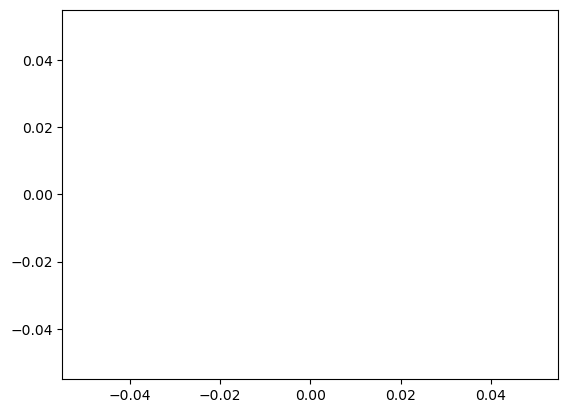

In [ ]:
dataC11Fz = dataC11[dataC11['Channel'] == 'Fz']
rmean1Fz = dataC11Fz.Slope.rolling('100s').mean()
plt.scatter(dataC11Fz['Start'], dataC11Fz['Slope'])
x, mean = zip(*sorted(zip(dataC11Fz['Start'], rmean1Fz),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))


ValueError: not enough values to unpack (expected 2, got 0)

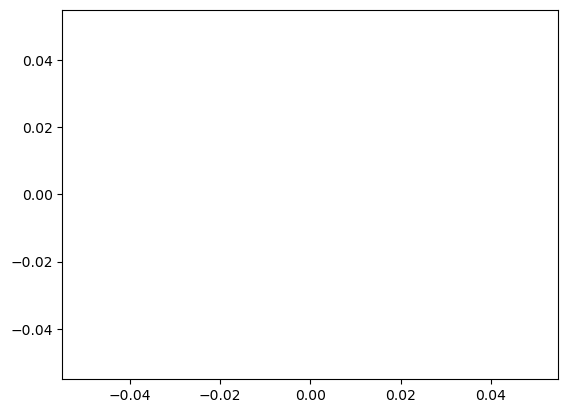

In [ ]:
rmean1 = dataC11.Slope.rolling('100s').mean()
plt.scatter(dataC11['Start'], dataC11['Slope'])
x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))

In [1]:
fig, ax = plt.subplots(6, 1, figsize = (15, 25))

### DATA
#dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
#dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
#dataC11 = dataC11.set_index('Time')
#rmean1 = dataC11.Slope.rolling('60s').mean()
dataC21 = data[data['Subject']=='C21'].sort_values(by=['Start']).reset_index(drop=True)
dataC21['Time'] = pd.to_datetime(dataC21['Start'],unit = 'h')
dataC21 = dataC21.set_index('Time')
rmean2 = dataC21.Slope.rolling('60s').mean()
dataE06 = data[data['Subject']=='E06'].sort_values(by=['Start']).reset_index(drop=True)
dataE06['Time'] = pd.to_datetime(dataE06['Start'],unit = 'h')
dataE06 = dataE06.set_index('Time')
rmean3 = dataE06.Slope.rolling('60s').mean()
dataE11 = data[data['Subject']=='E11'].sort_values(by=['Start']).reset_index(drop=True)
dataE11['Time'] = pd.to_datetime(dataE11['Start'],unit = 'h')
dataE11 = dataE11.set_index('Time')
rmean4 = dataE11.Slope.rolling('60s').mean()
dataS02 = data[data['Subject']=='S02'].sort_values(by=['Start']).reset_index(drop=True)
dataS02['Time'] = pd.to_datetime(dataS02['Start'],unit = 'h')
dataS02 = dataS02.set_index('Time')
rmean5 = dataS02.Slope.rolling('60s').mean()
dataS19 = data[data['Subject']=='S19'].sort_values(by=['Start']).reset_index(drop=True)
dataS19['Time'] = pd.to_datetime(dataS19['Start'],unit = 'h')
dataS19 = dataS19.set_index('Time')
rmean6 = dataS19.Slope.rolling('60s').mean()

# Plot individuals with running mean
#ax[0].set_title('C11')
#ax[0].scatter(dataC11['Start'], dataC11['Slope'])
#x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
#ax[0].plot(x, mean, color='C1')

ax[1].set_title('C21')
ax[1].scatter(dataC21['Start'], dataC21['Slope'])
x, mean = zip(*sorted(zip(dataC21['Start'], rmean2),key=lambda x: x[0]))
ax[1].plot(x, mean, color='C1')

ax[2].set_title('E06')
ax[2].scatter(dataE06['Start'], dataE06['Slope'])
x, mean = zip(*sorted(zip(dataE06['Start'], rmean3),key=lambda x: x[0]))
ax[2].plot(x, mean, color='C1')

ax[3].set_title('E11')
ax[3].scatter(dataE11['Start'], dataE11['Slope'])
x, mean = zip(*sorted(zip(dataE11['Start'], rmean4),key=lambda x: x[0]))
ax[3].plot(x, mean, color='C1')

ax[4].set_title('S02')
ax[4].scatter(dataS02['Start'], dataS02['Slope'])
x, mean = zip(*sorted(zip(dataS02['Start'], rmean5),key=lambda x: x[0]))
ax[4].plot(x, mean, color='C1')

ax[5].set_title('S19')
ax[5].scatter(dataS19['Start'], dataS19['Slope'])
x, mean = zip(*sorted(zip(dataS19['Start'], rmean6),key=lambda x: x[0]))
ax[5].plot(x, mean, color='C1')

NameError: name 'plt' is not defined